In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


### Mean reversion benchmark

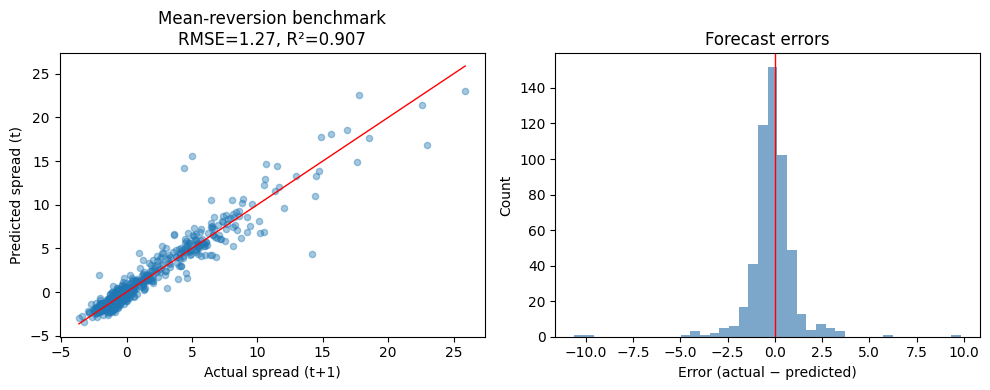

Share of between-country variance in total variance: 90.72%


In [ ]:
# mean-reversion as benchmark

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

full = pd.read_pickle("saved/df.dat")[["country", "year", "tgt_spread_t1", "tgt_spread"]].dropna()
fullte = full[full["year"] > 2014]
y_true = fullte["tgt_spread_t1"]
y_pred = fullte["tgt_spread"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

# show fit and prediction error

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
axes[0].scatter(y_true, y_pred, alpha=0.4, s=20)
axes[0].plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             color="red", linestyle="-", lw=1)
axes[0].set_xlabel("Actual spread (t+1)")
axes[0].set_ylabel("Predicted spread (t)")
axes[0].set_title(f"Mean-reversion benchmark\nRMSE={rmse:.2f}, R²={r2:.3f}")

errors = y_true - y_pred
axes[1].hist(errors, bins=40, color="steelblue", alpha=0.7)
axes[1].axvline(0, color="red", lw=1)
axes[1].set_title("Forecast errors")
axes[1].set_xlabel("Error (actual − predicted)")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

# how much of total variance is explained by between-country variance

df = fullte[["country", "tgt_spread_t1"]].dropna()
overall_mean = df["tgt_spread_t1"].mean()
n_i = df.groupby("country")["tgt_spread_t1"].count()
means_i = df.groupby("country")["tgt_spread_t1"].mean()

# weighted between-country variance

sst_between = ((n_i * (means_i - overall_mean)**2).sum()) / (len(df) - 1)
sst_total = ((df["tgt_spread_t1"] - overall_mean)**2).sum() / (len(df) - 1)
print(f"Share of between-country variance in total variance: {sst_between / sst_total:.2%}")

Almost 91% of the variation in next-year spreads is explained simply by the current spread — in other words, spreads are highly persistent.  On average, the mean-reversion benchmark misses by about 1.27 percentage points, or 127 bps.

About 91% of the variation in sovereign spreads reflects persistent cross-country differences, not year-to-year changes. This means spreads mainly differ because of structural and institutional factors, while short-term movements are small and harder to predict.

Since current pricing already embeds much of this institutional information, IQ variables may be crowded out by the spread level itself in the regularised models.

### Regularised regressions summary

In [3]:
from functions.summary import get_benchmark_stats, summarise_signal_regressions

import pandas as pd

df = pd.read_pickle("saved/df.dat")

benchmark_df_75 = get_benchmark_stats(df, 0.75)
benchmark_df_80 = get_benchmark_stats(df, 0.80)
benchmark_df_85 = get_benchmark_stats(df, 0.85)

benchmark_dfs = {
    0.75: benchmark_df_75,
    0.80: benchmark_df_80,
    0.85: benchmark_df_85
}

summarise_signal_regressions(
    "specs",
    base_name="signal",
    models=["ridge", "lasso", "elastic"],
    benchmark_dfs=benchmark_dfs
)

INCREMENTAL SIGNAL REGRESSIONS — PERFORMANCE SUMMARY (75-25 split)
Benchmark R²: 0.9074, Benchmark RMSE: 1.2728
                Model R²_test RMSE_test ΔR² vs Benchmark (p.p.) ΔRMSE vs Benchmark (bps) H1=Incremental signal present DM_stat  DM_p
                Ridge  0.9085    1.2651                   +0.11                     -0.8                      Rejected    1.03 0.303
                Lasso  0.9090    1.2619                   +0.16                     -1.1                      Rejected    1.00 0.319
Elastic Net (L1=0.75)  0.9087    1.2642                   +0.12                     -0.9                      Rejected    1.00 0.316
 Elastic Net (L1=0.5)  0.9086    1.2645                   +0.12                     -0.8                      Rejected    1.08 0.281
Elastic Net (L1=0.25)  0.9086    1.2649                   +0.12                     -0.8                      Rejected    1.08 0.281

INCREMENTAL SIGNAL REGRESSIONS — PERFORMANCE SUMMARY (80-20 split)
Benchmark R²: 0.9075, 

No models (5 evaluated) show significant incremental predictive power (DM test p ≥ 0.05) beyond the mean-reversion benchmark.

This indicates that macro and institutional quality variables do not provide statistically meaningful
incremental explanatory or predictive value beyond the benchmark for next-year spreads. Interpretability analyses (SHAP, stability selection) were therefore not conducted.

In [24]:
from functions.labels import all_labels
from functions.summary import summarise_priced_in_regressions

model_configs = [
    ("lasso", None),
    ("ridge", None),
    ("elastic", 0.25),
    ("elastic", 0.5),
    ("elastic", 0.75)
]

summarise_priced_in_regressions(
    specs_dir="specs",
    base_name="levels",
    suffix="",
    model_configs=model_configs,
    all_labels=all_labels,
    h=0
)

PRICED‑IN LEVEL REGRESSIONS — PERFORMANCE SUMMARY
 Horizon Split                   Model  R²_train  R²_test  RMSE_test
       0 75‑25 Elastic Net (L1 = 0.25)    0.8492   0.5086     2.9377
       0 75‑25  Elastic Net (L1 = 0.5)    0.8203   0.5097     2.9342
       0 75‑25 Elastic Net (L1 = 0.75)    0.8002   0.5175     2.9110
       0 75‑25                   Lasso    0.7904   0.5146     2.9197
       0 75‑25                   Ridge    0.7440   0.5549     2.7959
       0 80‑20 Elastic Net (L1 = 0.25)    0.8956   0.6021     2.5346
       0 80‑20  Elastic Net (L1 = 0.5)    0.8793   0.6116     2.5042
       0 80‑20 Elastic Net (L1 = 0.75)    0.8638   0.6030     2.5315
       0 80‑20                   Lasso    0.8828   0.6127     2.5007
       0 80‑20                   Ridge    0.8685   0.6231     2.4667
       0 85‑15 Elastic Net (L1 = 0.25)    0.8918   0.6327     2.4706
       0 85‑15  Elastic Net (L1 = 0.5)    0.8755   0.6389     2.4495
       0 85‑15 Elastic Net (L1 = 0.75)    0.8600   0.

The priced-in levels regressions yield out-of-sample R² values around 0.50–0.55,
indicating that macroeconomic and institutional quality variables together explain about
half of the cross-country variation in spreads.

Macroeconomic indicators such as the Current Account Balance, Real GDP Growth, and the
Standard Deviation of Inflation capture cyclical and external dynamics, while
institutional quality measures—including Monetary Freedom, Integrity of the Legal System,
Military Interference in Rule of Law, and Costs of Importing and Exporting—reflect
structural and governance-related differences across countries.

Ridge achieves slightly higher predictive accuracy, while Lasso and Elastic Net produce
comparable results with greater sparsity and interpretability. The consistency of key
variables across specifications suggests that both macroeconomic conditions and
institutional quality are systematically reflected in market pricing.

### Function

In [10]:
import os, time
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
from joblib import Parallel, delayed
import shap
import warnings

def filter_cols(cols, exclude_endings):
    return [c for c in cols if not any(c.endswith(ending) for ending in exclude_endings)]

def _yearwise_splits(years, min_train_years=8, stride=2):
    ys = np.asarray(years)
    uniq = np.sort(np.unique(ys))
    for k in range(min_train_years, len(uniq), stride):
        train = np.where(np.isin(ys, uniq[:k]))[0]
        val = np.where(ys == uniq[k])[0]
        yield train, val

def _rmse_for_param(param, X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2):
    rmse = []
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3, warm_start=False)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    for tr, va in _yearwise_splits(years, min_train_years, stride):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[va])
        rmse.append(np.sqrt(mean_squared_error(y.iloc[va], pred)))
    return param, float(np.mean(rmse)) if rmse else np.inf

def choose_param_expanding_fast(X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2, n_jobs=-1):
    if model_type == 'lasso':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            lasso_cv = LassoCV(alphas=alphas, cv=cv_folds, max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            lasso_cv.fit(X, y)
            return lasso_cv.alpha_

    elif model_type == 'elastic':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=[l1_ratio], cv=cv_folds,
                                    max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            elastic_cv.fit(X, y)
            return elastic_cv.alpha_

    params_coarse = np.logspace(0, 5, 15) if model_type == 'ridge' else np.logspace(-4, 1, 12)
    coarse = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(params_coarse, reverse=True)
    )
    p0 = min(coarse, key=lambda t: t[1])[0]
    low, high = p0/5, p0*5
    fine_grid = np.logspace(np.log10(low), np.log10(high), 8)
    fine = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(fine_grid, reverse=True)
    )
    return min(fine, key=lambda t: t[1])[0]

def _fit_model_for_factor(factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                         y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic):
    param = optimal_param * factor
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)

    model.fit(X_train, y_train_adj)
    y_pred_test_adj = model.predict(X_test)
    y_pred_train_adj = model.predict(X_train)

    if not agnostic:
        y_pred_test = spread_test + y_pred_test_adj
        y_pred_train = spread_train + y_pred_train_adj
    else:
        y_pred_test = y_pred_test_adj
        y_pred_train = y_pred_train_adj

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    active_vars = np.sum(model.coef_ != 0)

    if not agnostic:
        e_benchmark = y_test - spread_test
        e_model = y_test - y_pred_test
        dm_stat, dm_p = _dm_test(e_benchmark, e_model)
    else:
        dm_stat, dm_p = np.nan, np.nan

    return {
        'factor': factor,
        'param': param,
        'R²_train': r2_train,
        'R²_test': r2_test,
        'RMSE_test': rmse_test,
        'Active_vars': active_vars,
        'DM_stat': dm_stat,
        'DM_p': dm_p,
        'model': model,
        'predictions': y_pred_test
    }

def _dm_test(e0, e1):
    d = e0**2 - e1**2
    T = len(d)
    v = np.var(d, ddof=1)
    if T < 2 or v == 0 or np.isnan(v):
        return np.nan, np.nan
    stat = d.mean() / np.sqrt(v / T)
    pval = 2 * (1 - norm.cdf(abs(stat)))
    return stat, pval

def cluster_features(X_train, y_train=None, corr_threshold=0.75, method='complete'):
    def extract_core(var):
        suffixes = ['_delta3', '_delta', '_t-5', '_t-3', '_t-2', '_t-1', '_ma10', '_ma5', '_ma3']
        for s in suffixes:
            if var.endswith(s):
                return var[:-len(s)]
        return var

    core_groups = {}
    for v in X_train.columns:
        core = extract_core(v)
        core_groups.setdefault(core, []).append(v)

    cluster_map = {}
    representative_vars = []
    cluster_id = 0
    cluster_records = []

    for core, vars_in_core in core_groups.items():
        if len(vars_in_core) == 1:
            cluster_id += 1
            var = vars_in_core[0]
            cluster_map[cluster_id] = [var]
            representative_vars.append(var)
            cluster_records.append({'variable': var, 'cluster': cluster_id})
            continue

        corr_matrix = X_train[vars_in_core].corr().abs()
        corr_matrix = corr_matrix.fillna(0).clip(0, 1)
        distance_matrix = 1 - corr_matrix
        distance_matrix = np.where(np.isfinite(distance_matrix), distance_matrix, 1.0)
        condensed_dist = squareform(distance_matrix, checks=False)
        linkage_matrix = linkage(condensed_dist, method=method)
        clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

        for subcluster_id in np.unique(clusters):
            cluster_id += 1
            cluster_vars = [vars_in_core[i] for i, c in enumerate(clusters) if c == subcluster_id]
            cluster_map[cluster_id] = cluster_vars

            if y_train is not None:
                corrs = X_train[cluster_vars].corrwith(y_train)
                rep_var = corrs.abs().idxmax()
            else:
                variances = X_train[cluster_vars].var()
                rep_var = variances.idxmax()

            # Guard against NaN representative (can occur if correlation/variance all NaN)
            if pd.isna(rep_var):
                print(f"Warning: cluster {cluster_id} had no valid representative (NaN values), skipping it.")
                continue
            representative_vars.append(rep_var)
            for v in cluster_vars:
                cluster_records.append({'variable': v, 'cluster': cluster_id})

    cluster_df = pd.DataFrame(cluster_records)
    return representative_vars, cluster_map, cluster_df

def extract_core_variable(var_name):
    suffixes = ['_delta3', '_delta', '_t-5', '_t-4', '_t-3', '_t-2', '_t-1',
                '_ma10', '_ma5', '_ma3']
    for suffix in suffixes:
        if var_name.endswith(suffix):
            return var_name[:-len(suffix)]
    return var_name

def aggregate_by_core_variable(importance_df):
    importance_df = importance_df.copy()
    importance_df['core_variable'] = importance_df['variable'].apply(extract_core_variable)

    agg_dict = {'variable': lambda x: list(x)}

    if 'shap_importance' in importance_df.columns:
        agg_dict['shap_importance'] = 'sum'
    if 'shap_importance_pct' in importance_df.columns:
        agg_dict['shap_importance_pct'] = 'sum'
    if 'selection_frequency' in importance_df.columns:
        agg_dict['selection_frequency'] = 'mean'
    if 'mean_coef' in importance_df.columns:
        agg_dict['mean_coef'] = 'mean'
    if 'std_coef' in importance_df.columns:
        agg_dict['std_coef'] = 'mean'

    core_agg = importance_df.groupby('core_variable').agg(agg_dict).reset_index()
    core_agg['n_variants'] = core_agg['variable'].apply(len)
    core_agg = core_agg.rename(columns={'variable': 'variants'})

    if 'shap_importance' in core_agg.columns:
        core_agg = core_agg.sort_values('shap_importance', key=abs, ascending=False)
    elif 'selection_frequency' in core_agg.columns:
        core_agg = core_agg.sort_values('selection_frequency', ascending=False)

    return core_agg

def identify_cross_variable_correlations(X, threshold=0.75):
    var_to_core = {var: extract_core_variable(var) for var in X.columns}

    corr_matrix = X.corr().abs()

    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]

            core1 = var_to_core[var1]
            core2 = var_to_core[var2]

            if core1 != core2 and corr_val > threshold:
                high_corr_pairs.append({
                    'core_variable_1': core1,
                    'core_variable_2': core2,
                    'correlation': corr_val
                })

    if not high_corr_pairs:
        return pd.DataFrame()

    pairs_df = pd.DataFrame(high_corr_pairs)

    pairs_df['pair'] = pairs_df.apply(
        lambda row: tuple(sorted([row['core_variable_1'], row['core_variable_2']])),
        axis=1
    )

    result = pairs_df.loc[pairs_df.groupby('pair')['correlation'].idxmax()].copy()
    result = result[['core_variable_1', 'core_variable_2', 'correlation']].sort_values('correlation', ascending=False)
    result = result.reset_index(drop=True)

    return result

def calculate_shap_importance(model, X_test, max_samples=500):
    X_sample = X_test if len(X_test) <= max_samples else X_test.sample(max_samples, random_state=42)

    if hasattr(model, 'coef_'):
        explainer = shap.LinearExplainer(model, X_sample)
    else:
        explainer = shap.Explainer(model.predict, X_sample)

    shap_values = explainer(X_sample)

    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
    else:
        shap_vals = shap_values

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    shap_df = pd.DataFrame({
        'variable': X_test.columns,
        'shap_importance': mean_abs_shap,
        'shap_importance_pct': mean_abs_shap / mean_abs_shap.sum() * 100
    }).sort_values('shap_importance', ascending=False)

    return shap_df, shap_values

def stability_selection(X_train, y_train, model_type='lasso', alpha=None, l1_ratio=0.5,
                       n_iterations=100, subsample_frac=0.8, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X_train)
    subsample_size = int(n_samples * subsample_frac)

    selection_counts = {col: 0 for col in X_train.columns}
    coef_values = {col: [] for col in X_train.columns}

    for i in range(n_iterations):
        idx = np.random.choice(n_samples, size=subsample_size, replace=False)
        X_sub = X_train.iloc[idx]
        y_sub = y_train.iloc[idx]

        if model_type == 'lasso':
            if alpha is None:
                model = LassoCV(max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = Lasso(alpha=alpha, max_iter=2000, tol=1e-3)
        elif model_type == 'elastic':
            if alpha is None:
                model = ElasticNetCV(l1_ratio=l1_ratio, max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
        elif model_type == 'ridge':
            model = Ridge(alpha=alpha if alpha else 1.0)

        model.fit(X_sub, y_sub)

        for col, coef in zip(X_train.columns, model.coef_):
            if coef != 0:
                selection_counts[col] += 1
                coef_values[col].append(coef)

    stability_df = pd.DataFrame({
        'variable': X_train.columns,
        'selection_frequency': [selection_counts[col] / n_iterations for col in X_train.columns],
        'mean_coef': [np.mean(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'std_coef': [np.std(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'n_selections': [selection_counts[col] for col in X_train.columns]
    }).sort_values('selection_frequency', ascending=False)

    stability_df['stable'] = stability_df['selection_frequency'] >= 0.8

    return stability_df

def run_unified_regularized_regression(
    name_prefix="base",
    data_path="saved/df.dat",
    macro_cols=None,
    iq_cols=None,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=[0.5, 1.0, 2.0],
    l1_ratios=[0.5],
    use_clustering=True,
    corr_threshold=0.85,
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    stability_iterations=100,
    save_results=True,
    output_dir="specs",
    n_jobs=-1,
    parallel_param_factors=True,
    compute_shap=True,
    max_shap_samples=500,
    force_interpretability=False,
    r2_convergence_threshold=1e-4,
    r2_convergence_count=3,
    multicollinearity_check=True,
    perform_interpretability=True,
):
    print(f"\n{'='*80}")
    print(f"UNIFIED REGULARIZED REGRESSION: {name_prefix.upper()}")
    print(f"Specification: {'Agnostic (β unrestricted)' if agnostic else 'β=1 (fixed at mean reversion)'}")
    print(f"Models: {', '.join([m.upper() for m in model_types])}")
    if 'elastic' in model_types:
        print(f"Elastic Net L1 ratios: {l1_ratios}")
    if use_clustering:
        print(f"Feature clustering: ON (threshold={corr_threshold})")
    if perform_interpretability:
        print(f"Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)")
    print(f"R² convergence: Stop after {r2_convergence_count} consecutive changes < {r2_convergence_threshold}")
    if force_interpretability:
        print("Force interpretability: ON (interpret even if DM test fails)")
    print(f"{'='*80}\n")
    start_time = time.time()

    # Load and prepare data
    df = pd.read_pickle(data_path)
    if agnostic:
        df = df[df[y_name].notna()]
    else:
        df = df[(df[y_name].notna()) & (df[spread_col].notna())]
    df[year_col] = df[year_col].astype(int)

    if macro_cols is None:
        macro_cols = []
    if iq_cols is None:
        iq_cols = []

    train_data = df[df[year_col] <= split_year].copy()
    test_data = df[df[year_col] > split_year].copy()

    print(f"Train: {train_data[year_col].min()}-{train_data[year_col].max()} ({len(train_data)} obs)")
    print(f"Test:  {test_data[year_col].min()}-{test_data[year_col].max()} ({len(test_data)} obs)\n")

    feature_cols = macro_cols + iq_cols
    if spread_col in feature_cols and not agnostic:
        feature_cols = [c for c in feature_cols if c != spread_col]

    X_train_raw = train_data[feature_cols].copy()
    X_test_raw = test_data[feature_cols].copy()
    y_train = train_data[y_name].copy()
    y_test = test_data[y_name].copy()
    years_train = train_data[year_col].values

    # Adjust dependent variable for non-agnostic mode (β=1)
    if not agnostic:
        if spread_col not in train_data.columns:
            raise ValueError(f"β=1 specification requires '{spread_col}' column")
        spread_train = train_data[spread_col].copy()
        spread_test = test_data[spread_col].copy()
        mask_train = spread_train.notna() & y_train.notna()
        mask_test = spread_test.notna() & y_test.notna()
        X_train_raw = X_train_raw.loc[mask_train]
        X_test_raw = X_test_raw.loc[mask_test]
        y_train = y_train.loc[mask_train]
        y_test = y_test.loc[mask_test]
        spread_train = spread_train.loc[mask_train]
        spread_test = spread_test.loc[mask_test]
        years_train = years_train[mask_train.values]
        y_train_adj = y_train - spread_train
        y_test_adj = y_test - spread_test

        print(f"β=1 specification active")
        print(f"After removing NaN: {len(y_train_adj)} train, {len(y_test_adj)} test obs")

        # Print benchmark if provided
        if r2_benchmark is not None or rmse_benchmark is not None:
            print(f"\nBenchmark metrics:")
            if r2_benchmark is not None:
                print(f"  R² (test): {r2_benchmark:.4f}")
            if rmse_benchmark is not None:
                print(f"  RMSE (test): {rmse_benchmark:.4f}")
        print()
    else:
        y_train_adj = y_train
        y_test_adj = y_test
        spread_train = None
        spread_test = None

    # Handle imputation
    cols_with_data = X_train_raw.columns[~X_train_raw.isna().all()]
    X_train_fit = X_train_raw[cols_with_data].copy()
    X_test_fit = X_test_raw[cols_with_data].copy()
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train_fit)
    X_test_imp = imputer.transform(X_test_fit)
    X_train_imp_df = pd.DataFrame(X_train_imp, index=X_train_fit.index, columns=cols_with_data)
    X_test_imp_df = pd.DataFrame(X_test_imp, index=X_test_fit.index, columns=cols_with_data)

    # Multicollinearity
    if multicollinearity_check:
        print(f"{'='*80}")
        print("MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)")
        print(f"{'='*80}\n")

        cross_corr = identify_cross_variable_correlations(X_train_imp_df, threshold=corr_threshold)
        if len(cross_corr) > 0:
            print(f"Found {len(cross_corr)} core variable pairs with correlation above {corr_threshold}:\n")
            display(cross_corr.head(20))
            print("\nNote: These correlations are reported for transparency.")
            print("Regularization handles multicollinearity. Interpretation focuses on stable patterns.\n")
        else:
            print(f"No cross-core-variable correlations above {corr_threshold} threshold.\n")

    # Clustering
    if use_clustering:
        print("Clustering variants of same variables...")
        representative_vars, cluster_map, cluster_df = cluster_features(
            X_train_imp_df, y_train_adj, corr_threshold=corr_threshold
        )
        print(f"  Original features: {len(X_train_imp_df.columns)}")
        print(f"  After clustering: {len(representative_vars)}")
        print(f"  Number of clusters: {len(cluster_map)}\n")
        X_train_clustered = X_train_imp_df[representative_vars]
        X_test_clustered = X_test_imp_df[representative_vars]
    else:
        X_train_clustered = X_train_imp_df
        X_test_clustered = X_test_imp_df
        cluster_map = {i: [col] for i, col in enumerate(X_train_imp_df.columns)}
        cluster_df = pd.DataFrame({'variable': X_train_imp_df.columns, 'cluster': range(len(X_train_imp_df.columns))})

    # Standardization
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_clustered),
                           index=X_train_clustered.index,
                           columns=X_train_clustered.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_clustered),
                          index=X_test_clustered.index,
                          columns=X_test_clustered.columns)
    feature_names = list(X_train.columns)
    print(f"Features used in models: {len(feature_names)}\n")

    # Main loop
    all_results = {}

    for model_type in model_types:
        if model_type == 'elastic':
            model_configs = [(model_type, l1_ratio) for l1_ratio in l1_ratios]
        else:
            model_configs = [(model_type, None)]

        for model_type, l1_ratio in model_configs:
            mname = model_type.upper() + (f" (L1={l1_ratio})" if l1_ratio is not None else "")
            print(f"\n{'-'*80}")
            print(f"RUNNING {mname}")
            print(f"{'-'*80}\n")

            # Select optimal parameter
            if use_expanding_cv:
                print("Selecting optimal parameter via expanding window CV...")
                optimal_param = choose_param_expanding_fast(
                    X_train, y_train_adj, years_train,
                    model_type=model_type, l1_ratio=(l1_ratio or 0.5),
                    min_train_years=min_train_years,
                    stride=cv_stride, n_jobs=n_jobs
                )
            else:
                if model_type == 'ridge':
                    params = np.logspace(0, 5, 20)
                else:
                    params = np.logspace(-4, 1, 20)
                best_score = -np.inf
                optimal_param = params[0]
                for p in params:
                    if model_type == 'lasso':
                        m = Lasso(alpha=p, max_iter=2000, tol=1e-3)
                    elif model_type == 'ridge':
                        m = Ridge(alpha=p)
                    elif model_type == 'elastic':
                        m = ElasticNet(alpha=p, l1_ratio=(l1_ratio or 0.5),
                                       max_iter=2000, tol=1e-3)
                    m.fit(X_train, y_train_adj)
                    score = m.score(X_train, y_train_adj)
                    if score > best_score:
                        best_score = score
                        optimal_param = p
            print(f"Optimal parameter: {optimal_param:.6f}\n")

            # Parameter scaling loop
            results_rows = []
            models = {}
            r2_history = []
            convergence_counter = 0

            for factor in param_factors:
                result = _fit_model_for_factor(
                    factor, optimal_param, X_train, X_test,
                    y_train_adj, y_test_adj, y_train, y_test,
                    spread_train, spread_test, model_type,
                    (l1_ratio or 0.5), agnostic
                )

                # Stop and do not include models with zero active variables
                if model_type in ['lasso', 'elastic'] and result['Active_vars'] == 0:
                    print(f"Stopping: model has 0 active variables at factor {factor}\n")
                    break

                results_rows.append({
                    k: v for k, v in result.items() if k not in ['model', 'predictions']
                })
                models[result['factor']] = (result['model'], result['predictions'])

                # Convergence check
                r2_test = result['R²_test']
                if len(r2_history) > 0:
                    r2_change = abs(r2_test - r2_history[-1])
                    if r2_change < r2_convergence_threshold:
                        convergence_counter += 1
                        if convergence_counter >= r2_convergence_count:
                            print(f"Early stopping: R² converged after {r2_convergence_count} iterations.\n")
                            break
                    else:
                        convergence_counter = 0
                r2_history.append(r2_test)

            if not results_rows:
                print(f"No valid results for {mname}, skipping...\n")
                continue

            results_df = pd.DataFrame(results_rows)
            display(results_df)

            # Identify best model by test R²
            best_idx = results_df['R²_test'].idxmax()
            best_row = results_df.iloc[best_idx]
            best_model, best_pred = models[best_row['factor']]

            # --- Summarize results ---
            print(f"\nBest {mname}:")
            print(f"  Parameter: {best_row['param']:.6f}")
            print(f"  R² (test): {best_row['R²_test']:.4f}")

            # Benchmark deltas
            if r2_benchmark is not None:
                delta_r2_pp = (best_row['R²_test'] - r2_benchmark) * 100
                print(f"  ΔR² vs benchmark: {delta_r2_pp:+.2f} p.p.")

            print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")

            if rmse_benchmark is not None:
                delta_rmse = best_row['RMSE_test'] - rmse_benchmark
                print(f"  ΔRMSE vs benchmark: {delta_rmse:+.4f}")

            print(f"  Active vars: {int(best_row['Active_vars'])}")

            # Print active variable names for sparse models with few variables
            if model_type in ['lasso', 'elastic'] and 0 < int(best_row['Active_vars']) <= 10:
                active_vars = [name for name, coef in zip(feature_names, best_model.coef_) if coef != 0]
                print(f"  Active variables: {', '.join(active_vars)}")

            # DM test statistics
            if not agnostic and not np.isnan(best_row['DM_stat']):
                print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")
            print()

            # ALWAYS SAVE MAIN RESULTS
            if save_results:
                os.makedirs(output_dir, exist_ok=True)
                suffix = (
                    f"{'_agn' if agnostic else ''}"
                    f"{f'_l1_{l1_ratio}' if model_type == 'elastic' else ''}"
                    f"{'_clust' if use_clustering else ''}"
                )
                results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                pd.Series(best_model.coef_, index=feature_names).to_pickle(
                    f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat"
                )
                if use_clustering:
                    cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

            # --- Interpretability logic ---
            should_skip_interpretability = False
            skip_reason = None

            if not perform_interpretability:
                should_skip_interpretability = True
                skip_reason = "interpretability disabled by user"
            elif int(best_row['Active_vars']) == 0:
                should_skip_interpretability = True
                skip_reason = "model has 0 active variables"
            elif not agnostic and not force_interpretability:
                if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                    should_skip_interpretability = True
                    skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"
            elif best_row['DM_stat']<0 and best_row['DM_p']<0.05:
                should_skip_interpretability = True
                skip_reason = f"forecast errors differ significantly from benchmark (DM p={best_row['DM_p']:.3f}), but the sign indicates incremental noise"

            if should_skip_interpretability:
                print(f"Skipping interpretability analysis: {skip_reason}\n")
                if skip_reason and "benchmark" in skip_reason:
                    print("Interpretation: Macro/IQ variables do not provide statistically significant")
                    print("incremental predictive power beyond the mean reversion benchmark.\n")

                model_key = f"{model_type}_l1_{l1_ratio}" if l1_ratio is not None else model_type
                all_results[model_key] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'predictions': best_pred,
                    'skipped_interpretability': True,
                    'skip_reason': skip_reason
                }
                if l1_ratio is not None:
                    all_results[model_key]['l1_ratio'] = l1_ratio
                continue

            # --- Perform interpretability analysis ---
            print(f"\n{'='*80}")
            if agnostic:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
            else:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
            print(f"({mname})")
            print(f"{'='*80}\n")

            # METHOD 1: SHAP
            print(f"{'='*80}")
            print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
            print(f"{'='*80}\n")

            shap_df, core_shap = None, None
            if compute_shap:
                try:
                    print("Computing SHAP values...")
                    shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                    core_shap = aggregate_by_core_variable(shap_df)
                    core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                    if len(core_shap_nonzero) > 0:
                        print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                        display(core_shap_nonzero.head(20))
                    else:
                        print("\nNo core variables with meaningful SHAP importance\n")
                except Exception as e:
                    print(f"SHAP computation failed: {str(e)}")
                    print("Skipping SHAP analysis...\n")

            # METHOD 2: Stability Selection
            print(f"\n{'='*80}")
            print(f"METHOD 2: STABILITY SELECTION")
            print(f"{'='*80}\n")

            if model_type == 'ridge':
                print(f"Skipping stability selection for Ridge regression.")
                print("Ridge does not perform variable selection - all features have non-zero coefficients.")
                print("For feature importance with Ridge, refer to SHAP values above.\n")
                stability = None
                core_stability = None
            else:
                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=(l1_ratio or 0.5),
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

            # Save interpretability results
            if save_results:
                suffix = (
                    f"{'_agn' if agnostic else ''}"
                    f"{f'_l1_{l1_ratio}' if model_type == 'elastic' else ''}"
                    f"{'_clust' if use_clustering else ''}"
                )
                if shap_df is not None:
                    shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                    if core_shap is not None:
                        core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                if stability is not None:
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if core_stability is not None and len(core_stability) > 0:
                        core_stability.to_pickle(
                            f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat"
                        )

            model_key = f"{model_type}_l1_{l1_ratio}" if l1_ratio is not None else model_type
            all_results[model_key] = {
                'results_df': results_df,
                'best_model': best_model,
                'best_row': best_row,
                'shap_importance': shap_df,
                'core_shap': core_shap,
                'stability_selection': stability,
                'core_stability': core_stability,
                'cross_correlations': cross_corr if multicollinearity_check else None,
                'cluster_map': cluster_map,
                'predictions': best_pred
            }
            if l1_ratio is not None:
                all_results[model_key]['l1_ratio'] = l1_ratio

    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"COMPLETED IN {elapsed:.1f}s")
    print(f"{'='*80}\n")
    return all_results

### Incremental signal regressions

In [40]:
from functions.utils import check_split_year
from functions.summary import get_benchmark_stats

# Load
df = pd.read_pickle("saved/df.dat")

# Define columns
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])

# Define other function inputs
split_shares = [0.75, 0.8, 0.85]
y_name = "tgt_spread_t1"
models = ['elastic']

# Iterate
for split_share in split_shares:
    split_year = check_split_year(df, y_name, split_share)
    if split_share != 0.75:
        name_prefix = f"signal_t1_{split_share*100:.0f}"
    else:
        name_prefix = "signal_t1"
    print(f"Split year for {split_share*100:.0f}-{(1-split_share)*100:.0f} split: {split_year}")
    benchmark_df = get_benchmark_stats(df, split_share=split_share)
    h_benchmark = benchmark_df[benchmark_df["horizon"] == 1].iloc[0]
    r2_benchmark = h_benchmark["R2_test"]
    rmse_benchmark = h_benchmark["RMSE_test"]

    # Add today's spread level as explanatory variable
    macro_cols += ["tgt_spread"]

    # Run specification
    results = run_unified_regularized_regression(
        name_prefix=name_prefix,
        data_path="saved/df.dat",
        macro_cols=macro_cols,
        iq_cols=iq_cols,
        y_name=y_name,
        spread_col="tgt_spread",
        year_col="year",
        split_year=split_year,
        model_types=models,
        agnostic=False,
        param_factors=np.logspace(-3, 10, 25),
        l1_ratios=[0.25, 0.5, 0.75],
        use_clustering=True,
        corr_threshold=0.9,
        use_expanding_cv=True,
        min_train_years=8,
        cv_stride=2,
        r2_benchmark=r2_benchmark,
        rmse_benchmark=rmse_benchmark,
        early_stop_threshold=0.10,
        stability_iterations=100,
        save_results=True,
        output_dir="specs",
        n_jobs=-1,
        parallel_param_factors=True,
        compute_shap=True,
        max_shap_samples=500,
        force_interpretability=False,
        r2_convergence_threshold=1e-4,
        r2_convergence_count=3,
        multicollinearity_check=True,
        perform_interpretability=True
    )

Split year for 75-25 split: 2014

UNIFIED REGULARIZED REGRESSION: SIGNAL_T1
Specification: β=1 (fixed at mean reversion)
Models: ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2014 (1564 obs)
Test:  2015-2023 (534 obs)

β=1 specification active
After removing NaN: 1564 train, 534 test obs

Benchmark metrics:
  R² (test): 0.9074
  RMSE (test): 1.2728

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)

Found 56 core variable pairs with correlation above 0.9:



,core_variable_1,core_variable_2,correlation
0,p5d_xrreg,p5d_xconst,0.9993
1,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.9992
2,p5d_democ,p5d_xconst,0.9990
3,p5d_democ,p5d_xrreg,0.9976
4,p5d_autoc,p5d_xrreg,0.9975
5,p5d_autoc,p5d_xconst,0.9949
6,p5d_democ,p5d_autoc,0.9911
7,fiw_b,fiw_pr,0.9873
8,fiw_f,fiw_cl,0.9753
9,fiw_a,fiw_pr,0.9719



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 640
  Number of clusters: 640

Features used in models: 640


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 1.623777

Stopping: model has 0 active variables at factor 6.189658188912603



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0016,0.9492,0.4857,2.9996,591,-12.5766,0.0000
1,0.0035,0.0057,0.9415,0.5481,2.8119,503,-12.4891,0.0000
2,0.0121,0.0197,0.9289,0.6712,2.3986,411,-10.1919,0.0000
3,0.0422,0.0685,0.9054,0.8292,1.7284,287,-5.2748,0.0000
4,0.1468,0.2383,0.8608,0.8846,1.4207,127,-3.1700,0.0015
5,0.5109,0.8296,0.8077,0.9053,1.2869,24,-0.8790,0.3794
6,1.7783,2.8875,0.7214,0.9086,1.2649,9,1.0787,0.2807



Best ELASTIC (L1=0.25):
  Parameter: 2.887529
  R² (test): 0.9086
  ΔR² vs benchmark: +0.12 p.p.
  RMSE (test): 1.2649
  ΔRMSE vs benchmark: -0.0079
  Active vars: 9
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg, wb_ny_gdp_defl_kd_zg_delta3, wb_ny_gdp_defl_kd_zg_delta, wb_ny_gdp_defl_kd_zg_ma3, wb_ny_gdp_defl_kd_zg_ma5, wb_ny_gdp_defl_kd_zg_ma10
  DM test: stat=1.08, p=0.281

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.281)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.885867

Stopping: model has 0 active v

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0009,0.9512,0.4855,3.0004,579,-12.2365,0.0000
1,0.0035,0.0031,0.9437,0.5315,2.8631,489,-12.5464,0.0000
2,0.0121,0.0107,0.9313,0.6387,2.5141,374,-10.9404,0.0000
3,0.0422,0.0374,0.9085,0.8237,1.7561,245,-5.2555,0.0000
4,0.1468,0.1300,0.8639,0.8809,1.4437,102,-3.1197,0.0018
5,0.5109,0.4526,0.8128,0.9039,1.2966,21,-1.2170,0.2236
6,1.7783,1.5753,0.7407,0.9086,1.2645,7,1.0778,0.2811



Best ELASTIC (L1=0.5):
  Parameter: 1.575319
  R² (test): 0.9086
  ΔR² vs benchmark: +0.12 p.p.
  RMSE (test): 1.2645
  ΔRMSE vs benchmark: -0.0084
  Active vars: 7
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg, wb_ny_gdp_defl_kd_zg_delta3, wb_ny_gdp_defl_kd_zg_delta, wb_ny_gdp_defl_kd_zg_ma3
  DM test: stat=1.08, p=0.281

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.281)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Stopping: model has 0 active variables at factor 21.54434690031882



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0005,0.9527,0.4965,2.9679,590,-11.8709,0.0000
1,0.0035,0.0017,0.9469,0.5142,2.9155,511,-12.4166,0.0000
2,0.0121,0.0059,0.9351,0.5792,2.7133,380,-12.1703,0.0000
3,0.0422,0.0204,0.9156,0.7936,1.9004,246,-6.3088,0.0000
4,0.1468,0.0709,0.8763,0.8702,1.5069,113,-3.4788,0.0005
5,0.5109,0.2469,0.8241,0.8989,1.3301,19,-2.1055,0.0352
6,1.7783,0.8594,0.7667,0.9087,1.2642,4,1.0019,0.3164
7,6.1897,2.9914,0.5509,0.9085,1.2653,2,1.0151,0.3100



Best ELASTIC (L1=0.75):
  Parameter: 0.859430
  R² (test): 0.9087
  ΔR² vs benchmark: +0.12 p.p.
  RMSE (test): 1.2642
  ΔRMSE vs benchmark: -0.0086
  Active vars: 4
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg
  DM test: stat=1.00, p=0.316

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.316)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


COMPLETED IN 229.4s

Split year for 80-20 split: 2016

UNIFIED REGULARIZED REGRESSION: SIGNAL_T1_80
Specification: β=1 (fixed at mean reversion)
Models: ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2016 (1692 obs)
Test:  2017-2023 (406 obs)

β

,core_variable_1,core_variable_2,correlation
0,p5d_xrreg,p5d_xconst,0.9993
1,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.9991
2,p5d_democ,p5d_xconst,0.9990
3,p5d_democ,p5d_xrreg,0.9975
4,p5d_autoc,p5d_xrreg,0.9975
5,p5d_autoc,p5d_xconst,0.9949
6,p5d_democ,p5d_autoc,0.9910
7,fiw_b,fiw_pr,0.9880
8,fiw_cl,fiw_f,0.9768
9,fiw_a,fiw_pr,0.9726



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 629
  Number of clusters: 629

Features used in models: 629


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 1.623777

Stopping: model has 0 active variables at factor 6.189658188912603



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0016,0.9442,0.7480,2.0085,563,-8.2192,0.0000
1,0.0035,0.0057,0.9367,0.7797,1.8778,513,-7.6089,0.0000
2,0.0121,0.0197,0.9251,0.8137,1.7269,400,-6.6745,0.0000
3,0.0422,0.0685,0.9002,0.8479,1.5602,280,-4.9523,0.0000
4,0.1468,0.2383,0.8570,0.8870,1.3450,122,-2.8873,0.0039
5,0.5109,0.8296,0.8117,0.9056,1.2291,24,-0.6508,0.5152
6,1.7783,2.8875,0.7325,0.9071,1.2191,9,-0.2351,0.8141



Best ELASTIC (L1=0.25):
  Parameter: 2.887529
  R² (test): 0.9071
  ΔR² vs benchmark: -0.04 p.p.
  RMSE (test): 1.2191
  ΔRMSE vs benchmark: +0.0024
  Active vars: 9
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg, wb_ny_gdp_defl_kd_zg_delta3, wb_ny_gdp_defl_kd_zg_delta, wb_ny_gdp_defl_kd_zg_ma3, wb_ny_gdp_defl_kd_zg_ma5, wb_ny_gdp_defl_kd_zg_ma10
  DM test: stat=-0.24, p=0.814

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.814)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.885867

Stopping: model has 0 active 

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0009,0.9462,0.7431,2.0278,569,-8.2604,0.0000
1,0.0035,0.0031,0.9388,0.7807,1.8735,501,-7.4831,0.0000
2,0.0121,0.0107,0.9274,0.8133,1.7285,364,-6.6860,0.0000
3,0.0422,0.0374,0.9034,0.8477,1.5611,249,-4.7676,0.0000
4,0.1468,0.1300,0.8590,0.8868,1.3459,95,-2.6889,0.0072
5,0.5109,0.4526,0.8162,0.9047,1.2349,18,-0.8130,0.4162
6,1.7783,1.5753,0.7501,0.9073,1.2180,7,-0.1153,0.9082



Best ELASTIC (L1=0.5):
  Parameter: 1.575319
  R² (test): 0.9073
  ΔR² vs benchmark: -0.02 p.p.
  RMSE (test): 1.2180
  ΔRMSE vs benchmark: +0.0012
  Active vars: 7
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg, wb_ny_gdp_defl_kd_zg_delta3, wb_ny_gdp_defl_kd_zg_delta, wb_ny_gdp_defl_kd_zg_ma3
  DM test: stat=-0.12, p=0.908

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.908)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Stopping: model has 0 active variables at factor 21.54434690031882



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0005,0.9479,0.7393,2.0426,578,-8.2056,0.0000
1,0.0035,0.0017,0.9419,0.7753,1.8965,509,-7.5435,0.0000
2,0.0121,0.0059,0.9312,0.8048,1.7676,377,-7.0143,0.0000
3,0.0422,0.0204,0.9107,0.8421,1.5897,264,-4.9876,0.0000
4,0.1468,0.0709,0.8708,0.8773,1.4011,111,-3.2582,0.0011
5,0.5109,0.2469,0.8260,0.9012,1.2573,18,-1.4413,0.1495
6,1.7783,0.8594,0.7754,0.9075,1.2165,4,0.0230,0.9817
7,6.1897,2.9914,0.5646,0.9064,1.2242,2,-0.7793,0.4358



Best ELASTIC (L1=0.75):
  Parameter: 0.859430
  R² (test): 0.9075
  ΔR² vs benchmark: +0.00 p.p.
  RMSE (test): 1.2165
  ΔRMSE vs benchmark: -0.0003
  Active vars: 4
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg
  DM test: stat=0.02, p=0.982

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.982)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


COMPLETED IN 211.7s

Split year for 85-15 split: 2018

UNIFIED REGULARIZED REGRESSION: SIGNAL_T1_85
Specification: β=1 (fixed at mean reversion)
Models: ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2018 (1808 obs)
Test:  2019-2023 (290 obs)

β

,core_variable_1,core_variable_2,correlation
0,p5d_xrreg,p5d_xconst,0.9992
1,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.9991
2,p5d_democ,p5d_xconst,0.9990
3,p5d_democ,p5d_xrreg,0.9974
4,p5d_autoc,p5d_xrreg,0.9974
5,p5d_autoc,p5d_xconst,0.9947
6,p5d_democ,p5d_autoc,0.9906
7,fiw_b,fiw_pr,0.9886
8,fiw_cl,fiw_f,0.9773
9,fiw_a,fiw_pr,0.9729



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 619
  Number of clusters: 619

Features used in models: 619


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 1.623777

Stopping: model has 0 active variables at factor 6.189658188912603



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0016,0.9430,0.8134,1.7499,568,-4.5238,0.0000
1,0.0035,0.0057,0.9357,0.8336,1.6524,492,-4.0316,0.0001
2,0.0121,0.0197,0.9239,0.8418,1.6115,384,-3.7153,0.0002
3,0.0422,0.0685,0.8999,0.8636,1.4963,259,-2.5481,0.0108
4,0.1468,0.2383,0.8584,0.8799,1.4043,110,-2.0766,0.0378
5,0.5109,0.8296,0.8168,0.8902,1.3423,23,-1.0912,0.2752
6,1.7783,2.8875,0.7404,0.8928,1.3264,9,-0.5436,0.5867



Best ELASTIC (L1=0.25):
  Parameter: 2.887529
  R² (test): 0.8928
  ΔR² vs benchmark: -0.11 p.p.
  RMSE (test): 1.3264
  ΔRMSE vs benchmark: +0.0068
  Active vars: 9
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg, wb_ny_gdp_defl_kd_zg_delta3, wb_ny_gdp_defl_kd_zg_delta, wb_ny_gdp_defl_kd_zg_ma3, wb_ny_gdp_defl_kd_zg_ma5, wb_ny_gdp_defl_kd_zg_ma10
  DM test: stat=-0.54, p=0.587

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.587)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.885867

Stopping: model has 0 active 

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0009,0.9451,0.8066,1.7817,561,-4.5923,0.0000
1,0.0035,0.0031,0.9379,0.8297,1.6717,477,-4.1041,0.0000
2,0.0121,0.0107,0.9259,0.8391,1.6252,365,-3.8436,0.0001
3,0.0422,0.0374,0.9029,0.8618,1.5060,228,-2.5637,0.0104
4,0.1468,0.1300,0.8604,0.8776,1.4176,88,-2.1642,0.0305
5,0.5109,0.4526,0.8210,0.8895,1.3468,16,-1.1106,0.2668
6,1.7783,1.5753,0.7571,0.8930,1.3251,7,-0.4171,0.6766



Best ELASTIC (L1=0.5):
  Parameter: 1.575319
  R² (test): 0.8930
  ΔR² vs benchmark: -0.09 p.p.
  RMSE (test): 1.3251
  ΔRMSE vs benchmark: +0.0055
  Active vars: 7
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg, wb_ny_gdp_defl_kd_zg_delta3, wb_ny_gdp_defl_kd_zg_delta, wb_ny_gdp_defl_kd_zg_ma3
  DM test: stat=-0.42, p=0.677

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.677)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Stopping: model has 0 active variables at factor 21.54434690031882



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.0010,0.0005,0.9467,0.7965,1.8278,578,-4.8300,0.0000
1,0.0035,0.0017,0.9409,0.8223,1.7077,497,-4.3389,0.0000
2,0.0121,0.0059,0.9294,0.8382,1.6298,378,-3.8718,0.0001
3,0.0422,0.0204,0.9100,0.8564,1.5354,246,-2.8495,0.0044
4,0.1468,0.0709,0.8713,0.8749,1.4332,103,-2.1318,0.0330
5,0.5109,0.2469,0.8300,0.8864,1.3653,18,-1.4628,0.1435
6,1.7783,0.8594,0.7823,0.8933,1.3235,4,-0.2649,0.7911
7,6.1897,2.9914,0.5719,0.8919,1.3319,2,-1.1242,0.2609



Best ELASTIC (L1=0.75):
  Parameter: 0.859430
  R² (test): 0.8933
  ΔR² vs benchmark: -0.06 p.p.
  RMSE (test): 1.3235
  ΔRMSE vs benchmark: +0.0039
  Active vars: 4
  Active variables: wb_fp_cpi_totl_zg_ma3, wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb_ny_gdp_defl_kd_zg
  DM test: stat=-0.26, p=0.791

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.791)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


COMPLETED IN 216.6s



### Priced-in level regressions

In [11]:
from functions.utils import check_split_year

# Load
df = pd.read_pickle("saved/df.dat")

# Define columns
id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])

# Define other function inputs
split_shares = [0.75, 0.8, 0.85]
y_name = "tgt_spread"
models = ['lasso', 'ridge', 'elastic']

# Iterate
for split_share in split_shares:
    print(f"Runnning {split_share*100:.0f}-{(1-split_share)*100:.0f} split...")
    split_year = check_split_year(df, y_name, split_share)
    if split_share != 0.75:
        name_prefix = f"levels_t0_{split_share*100:.0f}"
    else:
        name_prefix = "levels_t0"
    print(f"Split year for {split_share*100:.0f}-{(1-split_share)*100:.0f} split: {split_year}")

    # Run specification
    results = run_unified_regularized_regression(
        name_prefix=name_prefix,
        data_path="saved/df.dat",
        macro_cols=macro_cols,
        iq_cols=iq_cols,
        use_clustering=True,
        corr_threshold=0.9,
        y_name=y_name,
        spread_col="tgt_spread",
        year_col="year",
        split_year=split_year,
        model_types=models,
        agnostic=True,
        param_factors=np.logspace(-2, 5, 15),
        l1_ratios=[0.25, 0.5, 0.75],
        use_expanding_cv=True,
        min_train_years=8,
        cv_stride=2,
        r2_benchmark=None,
        rmse_benchmark=None,
        early_stop_threshold=0.10,
        save_results=True,
        output_dir="specs",
        n_jobs=-1
    )

Runnning 75-25 split...
Split year for 75-25 split: 2015

UNIFIED REGULARIZED REGRESSION: LEVELS_T0
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2015 (1652 obs)
Test:  2016-2024 (541 obs)

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)

Found 60 core variable pairs with correlation above 0.9:



,core_variable_1,core_variable_2,correlation
0,p5d_democ,p5d_xconst,0.999063
1,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.999056
2,p5d_xrreg,p5d_xconst,0.998977
3,p5d_democ,p5d_xrreg,0.997217
4,p5d_autoc,p5d_xrreg,0.997004
5,p5d_autoc,p5d_xconst,0.993404
6,p5d_democ,p5d_autoc,0.989513
7,fiw_b,fiw_pr,0.988235
8,fiw_cl,fiw_f,0.976274
9,fiw_a,fiw_pr,0.974487



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 634
  Number of clusters: 634

Features used in models: 634


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.963680,-0.100415,4.396000,632,NaN,NaN
1,0.031623,0.000120,0.963665,-0.084150,4.363390,629,NaN,NaN
2,0.100000,0.000379,0.963350,-0.049959,4.294035,605,NaN,NaN
3,0.316228,0.001199,0.961327,-0.009447,4.210379,542,NaN,NaN
4,1.000000,0.003793,0.954384,0.178697,3.797790,446,NaN,NaN
5,3.162278,0.011994,0.939810,0.432268,3.157555,329,NaN,NaN
6,10.000000,0.037927,0.915739,0.472107,3.044755,203,NaN,NaN
7,31.622777,0.119935,0.862338,0.495854,2.975484,86,NaN,NaN
8,100.000000,0.379269,0.790401,0.514568,2.919736,24,NaN,NaN
9,316.227766,1.199354,0.680979,0.303349,3.497735,7,NaN,NaN



Best LASSO:
  Parameter: 0.379269
  R² (test): 0.5146
  RMSE (test): 2.9197
  Active vars: 24


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 19 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.564296,21.183727,5
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.561254,21.069518,7
12,efw_2d_military_interference,"[efw_2d_military_interference_ma10, efw_2d_mil...",0.302574,11.358659,5
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.253023,9.498501,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.245889,9.230686,7
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_ma3, efw_2b_impartial...",0.166839,6.263139,5
88,wb_fp_cpi_totl_zg,"[wb_fp_cpi_totl_zg, wb_fp_cpi_totl_zg_ma10, wb...",0.152605,5.728794,6
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.105727,3.968998,8
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma3, efw_5aii_...",0.055045,2.066408,8
99,wb_ny_gdp_petr_rt_zs,"[wb_ny_gdp_petr_rt_zs_delta, wb_ny_gdp_petr_rt...",0.050091,1.880408,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 8 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_2d_military_interference,[efw_2d_military_interference_ma10],1.000,-0.340850,0.083244,1
1,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000,-0.637692,0.130343,1
5,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma5],1.000,-0.328675,0.052443,1
4,ief_monetary_freedom,[ief_monetary_freedom_t-3],0.970,-0.793808,0.354935,1
2,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],0.930,-0.114641,0.059240,1
3,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma10, efw_...",0.895,-0.154545,0.078826,2
6,wb_ny_gdp_petr_rt_zs,[wb_ny_gdp_petr_rt_zs_delta],0.800,0.272866,0.069735,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 174.867862



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,1.748679e+00,0.961864,-0.000488,4.191653,634,NaN,NaN
1,0.031623,5.529807e+00,0.958190,0.061217,4.060336,634,NaN,NaN
2,0.100000,1.748679e+01,0.951627,0.194124,3.761953,634,NaN,NaN
3,0.316228,5.529807e+01,0.940659,0.336398,3.413761,634,NaN,NaN
4,1.000000,1.748679e+02,0.923693,0.430671,3.161994,634,NaN,NaN
5,3.162278,5.529807e+02,0.897645,0.488617,2.996765,634,NaN,NaN
6,10.000000,1.748679e+03,0.851113,0.535431,2.856306,634,NaN,NaN
7,31.622777,5.529807e+03,0.744029,0.554868,2.795915,634,NaN,NaN
8,100.000000,1.748679e+04,0.537628,0.524745,2.888967,634,NaN,NaN
9,316.227766,5.529807e+04,0.316116,0.460726,3.077403,634,NaN,NaN



Best RIDGE:
  Parameter: 5529.807340
  R² (test): 0.5549
  RMSE (test): 2.7959
  Active vars: 634


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.494245,4.847237,9
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.335004,3.285497,7
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.274670,2.693782,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.252809,2.479386,7
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.251828,2.469765,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-1, efw_5aii_...",0.247966,2.431892,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.219330,2.151048,6
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_delta3, efw_2b_impart...",0.218597,2.143857,5
33,efw_4diii_freedom_of_foreigners_to_visit,"[efw_4diii_freedom_of_foreigners_to_visit_t-3,...",0.198621,1.947943,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.192163,1.884608,5



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 10000.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.963678,-0.102981,4.401122,634,NaN,NaN
1,0.031623,0.000120,0.963653,-0.085342,4.365789,633,NaN,NaN
2,0.100000,0.000379,0.963390,-0.050065,4.294252,631,NaN,NaN
3,0.316228,0.001199,0.961672,0.011039,4.167436,608,NaN,NaN
4,1.000000,0.003793,0.956859,0.098377,3.979165,569,NaN,NaN
5,3.162278,0.011994,0.947802,0.293544,3.522264,505,NaN,NaN
6,10.000000,0.037927,0.931405,0.432754,3.156206,407,NaN,NaN
7,31.622777,0.119935,0.904009,0.479872,3.022280,297,NaN,NaN
8,100.000000,0.379269,0.849222,0.508562,2.937741,181,NaN,NaN
9,316.227766,1.199354,0.761361,0.499990,2.963254,88,NaN,NaN



Best ELASTIC (L1=0.25):
  Parameter: 0.379269
  R² (test): 0.5086
  RMSE (test): 2.9377
  Active vars: 181


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.25))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.620143,7.928968,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.385783,4.932502,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.368986,4.717745,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.364376,4.658797,7
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.350585,4.482479,9
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.303633,3.882155,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma3, efw_5aii_...",0.231827,2.964075,8
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.228749,2.924718,5
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.224732,2.873356,7
12,efw_2d_military_interference,"[efw_2d_military_interference_ma10, efw_2d_mil...",0.200197,2.559661,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 104 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
4,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000000,-0.155814,0.030632,1
6,efw_2b_impartial_courts,[efw_2b_impartial_courts_ma3],1.000000,-0.121949,0.030020,1
5,efw_2a_judicial_independence,[efw_2a_judicial_independence_ma10],1.000000,-0.149647,0.042592,1
40,p5d_durable,[p5d_durable],1.000000,-0.137484,0.030460,1
45,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_t-5, wb_ny_gdp_minr_rt_z...",0.995000,0.062058,0.022937,2
47,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta]",0.990000,-0.082787,0.023595,2
42,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_t-3, wb_bn_cab_xoka_gd_z...",0.990000,-0.068413,0.030326,4
51,wb_tx_val_fuel_zs_un,"[wb_tx_val_fuel_zs_un_ma10, wb_tx_val_fuel_zs_...",0.985000,0.075988,0.029394,2
32,efw_ie_state_ownership,[efw_ie_state_ownership_ma10],0.980000,-0.222067,0.068203,1
36,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.980000,-0.166595,0.084016,4



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.963678,-0.099957,4.395084,634,NaN,NaN
1,0.031623,0.000120,0.963658,-0.085576,4.366258,634,NaN,NaN
2,0.100000,0.000379,0.963393,-0.048819,4.291702,624,NaN,NaN
3,0.316228,0.001199,0.961584,0.016022,4.156925,577,NaN,NaN
4,1.000000,0.003793,0.955930,0.131464,3.905470,518,NaN,NaN
5,3.162278,0.011994,0.944683,0.352732,3.371488,428,NaN,NaN
6,10.000000,0.037927,0.924965,0.463164,3.070438,303,NaN,NaN
7,31.622777,0.119935,0.888626,0.497679,2.970094,196,NaN,NaN
8,100.000000,0.379269,0.820254,0.509748,2.934197,80,NaN,NaN
9,316.227766,1.199354,0.726070,0.435110,3.149644,40,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.379269
  R² (test): 0.5097
  RMSE (test): 2.9342
  Active vars: 80


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.5))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.546426,12.318291,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.353336,7.965386,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.261060,5.885170,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.254002,5.726058,5
12,efw_2d_military_interference,"[efw_2d_military_interference_ma10, efw_2d_mil...",0.247397,5.577171,5
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.241654,5.447697,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.205463,4.631834,9
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.191706,4.321711,6
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma3, efw_5aii_...",0.144621,3.260244,8
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.138701,3.126791,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 44 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
1,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000000,-0.153153,0.050417,1
2,efw_2b_impartial_courts,[efw_2b_impartial_courts_ma3],1.000000,-0.130797,0.043620,1
3,efw_2d_military_interference,[efw_2d_military_interference_ma10],1.000000,-0.270869,0.057867,1
4,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000000,-0.294900,0.037666,1
12,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.000000,-0.112567,0.043716,1
8,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],0.990000,-0.121914,0.046067,1
0,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.990000,0.093960,0.037128,2
16,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.973333,-0.305182,0.118028,3
11,efw_5aii_private_sector_credit,[efw_5aii_private_sector_credit_ma3],0.960000,-0.103735,0.041902,1
7,efw_4aiii_standard_deviation_of_tariff_rates,[efw_4aiii_standard_deviation_of_tariff_rates],0.960000,0.055161,0.023858,1



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.963679,-0.100070,4.395311,632,NaN,NaN
1,0.031623,0.000120,0.963662,-0.084526,4.364148,632,NaN,NaN
2,0.100000,0.000379,0.963379,-0.047260,4.288512,616,NaN,NaN
3,0.316228,0.001199,0.961462,0.013128,4.163033,560,NaN,NaN
4,1.000000,0.003793,0.955141,0.163787,3.832109,477,NaN,NaN
5,3.162278,0.011994,0.941889,0.411688,3.214276,367,NaN,NaN
6,10.000000,0.037927,0.919791,0.470709,3.048785,244,NaN,NaN
7,31.622777,0.119935,0.873971,0.506286,2.944538,134,NaN,NaN
8,100.000000,0.379269,0.800170,0.517463,2.911017,47,NaN,NaN
9,316.227766,1.199354,0.702578,0.341336,3.401037,24,NaN,NaN



Best ELASTIC (L1=0.75):
  Parameter: 0.379269
  R² (test): 0.5175
  RMSE (test): 2.9110
  Active vars: 47


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.75))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.495285,15.500015,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.354614,11.097688,5
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.306696,9.598103,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.302624,9.470652,7
12,efw_2d_military_interference,"[efw_2d_military_interference_ma10, efw_2d_mil...",0.292964,9.168359,5
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_ma3, efw_2b_impartial...",0.166089,5.197770,5
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.160066,5.009282,8
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.124562,3.898199,5
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma3, efw_5aii_...",0.099538,3.115044,8
93,wb_ny_gdp_defl_kd_zg,"[wb_ny_gdp_defl_kd_zg, wb_ny_gdp_defl_kd_zg_t-...",0.095857,2.999866,8



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 17 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
2,efw_2d_military_interference,[efw_2d_military_interference_ma10],1.000,-0.317335,0.075235,1
3,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000,-0.414190,0.064632,1
10,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma5],1.000,-0.342323,0.051010,1
5,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],0.990,-0.129201,0.054952,1
1,efw_2b_impartial_courts,[efw_2b_impartial_courts_ma3],0.980,-0.159025,0.065406,1
0,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.980,-0.139892,0.076022,1
13,wb_ny_gdp_pcap_kd,[wb_ny_gdp_pcap_kd_delta],0.930,-0.062646,0.031030,1
6,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma10, efw_...",0.930,-0.181481,0.072913,2
9,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.925,-0.476386,0.209519,2
7,efw_5aii_private_sector_credit,[efw_5aii_private_sector_credit_ma3],0.890,-0.097610,0.048855,1



COMPLETED IN 499.8s

Runnning 80-20 split...
Split year for 80-20 split: 2017

UNIFIED REGULARIZED REGRESSION: LEVELS_T0_80
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2017 (1780 obs)
Test:  2018-2024 (413 obs)

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)

Found 61 core variable pairs with correlation above 0.9:



,core_variable_1,core_variable_2,correlation
0,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.999012
1,p5d_democ,p5d_xconst,0.999012
2,p5d_xrreg,p5d_xconst,0.998965
3,p5d_democ,p5d_xrreg,0.997143
4,p5d_autoc,p5d_xrreg,0.996899
5,p5d_autoc,p5d_xconst,0.993250
6,p5d_democ,p5d_autoc,0.989191
7,fiw_b,fiw_pr,0.988497
8,fiw_cl,fiw_f,0.976849
9,fiw_a,fiw_pr,0.974106



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 627
  Number of clusters: 627

Features used in models: 627


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.006952

Stopping: model has 0 active variables at factor 1000.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000070,0.957721,0.107244,3.796439,625,NaN,NaN
1,0.031623,0.000220,0.957637,0.151205,3.701787,608,NaN,NaN
2,0.100000,0.000695,0.956725,0.246056,3.488828,573,NaN,NaN
3,0.316228,0.002198,0.951894,0.406048,3.096604,485,NaN,NaN
4,1.000000,0.006952,0.941385,0.508750,2.816187,378,NaN,NaN
5,3.162278,0.021984,0.921092,0.569346,2.636782,273,NaN,NaN
6,10.000000,0.069519,0.882847,0.612661,2.500667,146,NaN,NaN
7,31.622777,0.219839,0.810831,0.567293,2.643061,44,NaN,NaN
8,100.000000,0.695193,0.738799,0.449300,2.981725,16,NaN,NaN
9,316.227766,2.198393,0.510383,0.053039,3.909994,4,NaN,NaN



Best LASSO:
  Parameter: 0.069519
  R² (test): 0.6127
  RMSE (test): 2.5007
  Active vars: 146


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation, efw_3...",1.060929,9.299140,8
74,ief_monetary_freedom,"[ief_monetary_freedom_ma5, ief_monetary_freedo...",0.951012,8.335710,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.503271,4.411214,6
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.476440,4.176044,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.401159,3.516193,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.382694,3.354346,5
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma1...,0.378082,3.313921,5
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.321848,2.821024,7
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg, wb_ny_gdp_mktp_kd_zg_ma...",0.313519,2.748026,9
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.305951,2.681685,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 67 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
13,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],1.000000,-0.339571,0.066775,1
16,efw_4dii_capital_controls,[efw_4dii_capital_controls_t-5],1.000000,0.157206,0.058557,1
18,efw_5aii_private_sector_credit,[efw_5aii_private_sector_credit_t-3],1.000000,-0.170184,0.060969,1
6,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.177079,0.042437,1
48,wb_pa_nus_fcrf,[wb_pa_nus_fcrf_delta3],1.000000,0.080300,0.026062,1
44,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.000000,0.288152,0.048507,1
28,efw_gender_disparity_index,[efw_gender_disparity_index_ma10],1.000000,0.497335,0.105160,1
10,efw_4ai_trade_tax_revenue,[efw_4ai_trade_tax_revenue_t-3],0.990000,-0.231385,0.086350,1
25,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],0.990000,-0.426081,0.141964,1
50,wgi_governmenteffectiveness_estimate,[wgi_governmenteffectiveness_estimate_delta3],0.990000,-0.071283,0.038279,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 110.408951



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,1.104090e+00,0.957074,0.225993,3.534943,627,NaN,NaN
1,0.031623,3.491438e+00,0.954128,0.301439,3.358244,627,NaN,NaN
2,0.100000,1.104090e+01,0.948894,0.380220,3.163216,627,NaN,NaN
3,0.316228,3.491438e+01,0.939625,0.462746,2.945098,627,NaN,NaN
4,1.000000,1.104090e+02,0.925027,0.541878,2.719571,627,NaN,NaN
5,3.162278,3.491438e+02,0.903188,0.599950,2.541367,627,NaN,NaN
6,10.000000,1.104090e+03,0.868455,0.623125,2.466656,627,NaN,NaN
7,31.622777,3.491438e+03,0.797686,0.611648,2.503934,627,NaN,NaN
8,100.000000,1.104090e+04,0.639959,0.565775,2.647690,627,NaN,NaN
9,316.227766,3.491438e+04,0.414275,0.491836,2.864257,627,NaN,NaN



Best RIDGE:
  Parameter: 1104.089514
  R² (test): 0.6231
  RMSE (test): 2.4667
  Active vars: 627


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.599841,3.122865,7
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.560311,2.917066,9
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.457467,2.381643,6
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-3, efw_5aii_...",0.437311,2.276706,8
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.436119,2.270503,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.425510,2.215268,6
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.366776,1.909493,8
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.364380,1.897019,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.336302,1.750837,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.326125,1.697855,5



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 10000.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.957727,0.096642,3.818915,627,NaN,NaN
1,0.031623,0.000120,0.957708,0.123154,3.762458,627,NaN,NaN
2,0.100000,0.000379,0.957447,0.185739,3.625700,621,NaN,NaN
3,0.316228,0.001199,0.955641,0.283892,3.400158,606,NaN,NaN
4,1.000000,0.003793,0.950680,0.395969,3.122766,565,NaN,NaN
5,3.162278,0.011994,0.941223,0.488149,2.874628,502,NaN,NaN
6,10.000000,0.037927,0.924389,0.552466,2.687962,393,NaN,NaN
7,31.622777,0.119935,0.895606,0.602073,2.534614,303,NaN,NaN
8,100.000000,0.379269,0.838731,0.590587,2.570933,180,NaN,NaN
9,316.227766,1.199354,0.751180,0.524777,2.769867,84,NaN,NaN



Best ELASTIC (L1=0.25):
  Parameter: 0.119935
  R² (test): 0.6021
  RMSE (test): 2.5346
  Active vars: 303


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.25))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",1.059310,6.080713,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation, efw_3...",0.827906,4.752391,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.588975,3.380867,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.498710,2.862723,6
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.459507,2.637685,5
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg, wb_ny_gdp_mktp_kd_zg_ma...",0.416376,2.390107,9
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-3, efw_5aii_...",0.398965,2.290158,8
50,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs_ma10, efw_5cii_bure...",0.377650,2.167806,8
55,efw_5dii_business_permits,"[efw_5dii_business_permits_t-5, efw_5dii_busin...",0.362561,2.081194,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.357072,2.049684,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 187 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
4,efw_1di_top_marginal_income_tax_rate,[efw_1di_top_marginal_income_tax_rate_t-5],1.000000,-0.098188,0.031629,1
11,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.205277,0.036347,1
41,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-1, efw_5ci_regula...",1.000000,0.123937,0.036847,2
42,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs_t-3, efw_5cii_burea...",1.000000,0.008686,0.044604,2
26,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",1.000000,-0.213516,0.042959,2
65,p5d_autoc,[p5d_autoc_ma10],1.000000,-0.114182,0.039495,1
67,p5d_fragment,[p5d_fragment_t-3],1.000000,0.127616,0.043288,1
62,ief_property_rights,"[ief_property_rights_t-3, ief_property_rights_...",1.000000,0.129325,0.040601,2
83,wgi_governmenteffectiveness_estimate,[wgi_governmenteffectiveness_estimate_delta3],1.000000,-0.103933,0.038427,1
38,efw_5bv_cost_of_worker_dismissal,[efw_5bv_cost_of_worker_dismissal_ma10],1.000000,-0.130780,0.057754,1



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.957727,0.096792,3.818597,627,NaN,NaN
1,0.031623,0.000120,0.957708,0.123375,3.761983,627,NaN,NaN
2,0.100000,0.000379,0.957445,0.187135,3.622591,616,NaN,NaN
3,0.316228,0.001199,0.955513,0.296538,3.370003,587,NaN,NaN
4,1.000000,0.003793,0.949728,0.426831,3.041946,511,NaN,NaN
5,3.162278,0.011994,0.938221,0.514887,2.798538,424,NaN,NaN
6,10.000000,0.037927,0.917699,0.577274,2.612399,318,NaN,NaN
7,31.622777,0.119935,0.879320,0.611565,2.504200,201,NaN,NaN
8,100.000000,0.379269,0.808411,0.559497,2.666763,79,NaN,NaN
9,316.227766,1.199354,0.718571,0.458081,2.957858,42,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.119935
  R² (test): 0.6116
  RMSE (test): 2.5042
  Active vars: 201


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.5))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.937056,7.736126,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation, efw_3...",0.749098,6.184383,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.516200,4.261635,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.476813,3.936465,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.381792,3.151991,7
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.355347,2.933668,9
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma1...,0.312198,2.577438,5
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.295880,2.442717,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.294016,2.427327,5
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.287881,2.376683,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 109 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
2,efw_1di_top_marginal_income_tax_rate,[efw_1di_top_marginal_income_tax_rate_t-5],1.000000,-0.101123,0.040770,1
4,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000000,-0.174428,0.093866,1
9,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.169563,0.038908,1
23,efw_4dii_capital_controls,[efw_4dii_capital_controls_t-5],1.000000,0.139896,0.042057,1
20,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],1.000000,-0.305624,0.051154,1
46,p5d_autoc,[p5d_autoc_ma10],1.000000,-0.107166,0.040447,1
34,efw_5dii_business_permits,"[efw_5dii_business_permits_t-5, efw_5dii_busin...",1.000000,0.019336,0.040591,2
32,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.000000,-0.313178,0.076020,1
58,wb_ny_gdp_pcap_kd,[wb_ny_gdp_pcap_kd],1.000000,-0.140200,0.039594,1
62,wgi_governmenteffectiveness_estimate,[wgi_governmenteffectiveness_estimate_delta3],1.000000,-0.082710,0.036390,1



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.957726,0.096897,3.818375,627,NaN,NaN
1,0.031623,0.000120,0.957706,0.123285,3.762178,625,NaN,NaN
2,0.100000,0.000379,0.957428,0.188144,3.620342,607,NaN,NaN
3,0.316228,0.001199,0.955345,0.306428,3.346229,564,NaN,NaN
4,1.000000,0.003793,0.948872,0.445345,2.992412,474,NaN,NaN
5,3.162278,0.011994,0.935658,0.534434,2.741579,363,NaN,NaN
6,10.000000,0.037927,0.912318,0.584112,2.591183,250,NaN,NaN
7,31.622777,0.119935,0.863825,0.603038,2.531538,137,NaN,NaN
8,100.000000,0.379269,0.787586,0.553943,2.683521,45,NaN,NaN
9,316.227766,1.199354,0.692241,0.367796,3.194764,26,NaN,NaN



Best ELASTIC (L1=0.75):
  Parameter: 0.119935
  R² (test): 0.6030
  RMSE (test): 2.5315
  Active vars: 137


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.75))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.861403,9.734797,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.598100,6.759185,8
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.451238,5.099481,6
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.415599,4.696726,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.405331,4.580682,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.337162,3.810306,5
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma1...,0.297226,3.358984,5
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.272981,3.084986,9
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.256692,2.900902,7
37,efw_5ai_ownership_of_banks,"[efw_5ai_ownership_of_banks, efw_5ai_ownership...",0.217203,2.454631,7



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 67 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
5,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000,-0.380718,0.104655,1
13,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],1.000,-0.292272,0.057288,1
10,efw_4ai_trade_tax_revenue,[efw_4ai_trade_tax_revenue_t-3],1.000,-0.177921,0.064791,1
20,efw_5ci_regulatory_burden,[efw_5ci_regulatory_burden_t-3],1.000,0.144873,0.049565,1
21,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.000,-0.318572,0.103550,1
16,efw_4dii_capital_controls,[efw_4dii_capital_controls_t-5],1.000,0.113392,0.043981,1
31,p5d_autoc,[p5d_autoc_ma10],1.000,-0.090781,0.040755,1
32,p5d_durable,[p5d_durable],1.000,-0.206648,0.054521,1
39,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.000,0.240618,0.038861,1
25,fiw_a,[fiw_a_t-1],0.990,0.126439,0.056319,1



COMPLETED IN 567.2s

Runnning 85-15 split...
Split year for 85-15 split: 2019

UNIFIED REGULARIZED REGRESSION: LEVELS_T0_85
Specification: Agnostic (β unrestricted)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.25, 0.5, 0.75]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2019 (1898 obs)
Test:  2020-2024 (295 obs)

MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)

Found 61 core variable pairs with correlation above 0.9:



,core_variable_1,core_variable_2,correlation
0,wb_fp_cpi_totl_zg,wb_ny_gdp_defl_kd_zg,0.999000
1,p5d_democ,p5d_xconst,0.998978
2,p5d_xrreg,p5d_xconst,0.998954
3,p5d_democ,p5d_xrreg,0.997063
4,p5d_autoc,p5d_xrreg,0.996793
5,p5d_autoc,p5d_xconst,0.993085
6,fiw_b,fiw_pr,0.988896
7,p5d_democ,p5d_autoc,0.988853
8,fiw_cl,fiw_f,0.976834
9,fiw_a,fiw_pr,0.974276



Note: These correlations are reported for transparency.
Regularization handles multicollinearity. Interpretation focuses on stable patterns.

Clustering variants of same variables...
  Original features: 972
  After clustering: 614
  Number of clusters: 614

Features used in models: 614


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.006952

Stopping: model has 0 active variables at factor 1000.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000070,0.953078,0.402520,3.150945,612,NaN,NaN
1,0.031623,0.000220,0.953025,0.434883,3.064420,596,NaN,NaN
2,0.100000,0.000695,0.952251,0.509353,2.855378,563,NaN,NaN
3,0.316228,0.002198,0.947719,0.540453,2.763403,482,NaN,NaN
4,1.000000,0.006952,0.937096,0.503506,2.872340,377,NaN,NaN
5,3.162278,0.021984,0.917566,0.580466,2.640357,262,NaN,NaN
6,10.000000,0.069519,0.879357,0.630728,2.477149,143,NaN,NaN
7,31.622777,0.219839,0.807536,0.576631,2.652397,41,NaN,NaN
8,100.000000,0.695193,0.736282,0.470407,2.966538,15,NaN,NaN
9,316.227766,2.198393,0.493936,0.062862,3.946216,4,NaN,NaN



Best LASSO:
  Parameter: 0.069519
  R² (test): 0.6307
  RMSE (test): 2.4771
  Active vars: 143


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(LASSO)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation, efw_3...",0.969743,9.051031,8
74,ief_monetary_freedom,"[ief_monetary_freedom_ma3, ief_monetary_freedo...",0.927237,8.654302,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.487480,4.549856,6
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.478209,4.463329,6
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma1...,0.408504,3.812741,4
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.393647,3.674077,7
59,fiw_a,"[fiw_a_ma10, fiw_a_t-3, fiw_a_t-5, fiw_a_delta...",0.362868,3.386805,5
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.315877,2.948220,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.300582,2.805459,5
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.282178,2.633689,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 72 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",1.00,0.239680,0.077001,2
5,efw_2f_contracts,[efw_2f_contracts_delta3],1.00,-0.158592,0.038644,1
10,efw_4ai_trade_tax_revenue,[efw_4ai_trade_tax_revenue_t-3],1.00,-0.218844,0.076952,1
16,efw_4dii_capital_controls,[efw_4dii_capital_controls_t-5],1.00,0.191075,0.054208,1
18,efw_5aii_private_sector_credit,[efw_5aii_private_sector_credit_t-3],1.00,-0.174270,0.062951,1
13,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],1.00,-0.342970,0.055297,1
25,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.00,-0.457048,0.113600,1
51,wb_pa_nus_fcrf,[wb_pa_nus_fcrf_delta3],1.00,0.092640,0.024709,1
38,p5d_autoc,[p5d_autoc_ma10],1.00,-0.141063,0.053575,1
30,efw_gender_disparity_index,[efw_gender_disparity_index_ma10],1.00,0.458284,0.085036,1



--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 2.864150



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.028641,0.957182,0.493810,2.900252,614,NaN,NaN
1,0.031623,0.090572,0.956531,0.481346,2.935741,614,NaN,NaN
2,0.100000,0.286415,0.955076,0.471489,2.963508,614,NaN,NaN
3,0.316228,0.905724,0.953019,0.476355,2.949833,614,NaN,NaN
4,1.000000,2.864150,0.950374,0.487201,2.919124,614,NaN,NaN
5,3.162278,9.057237,0.946114,0.482469,2.932563,614,NaN,NaN
6,10.000000,28.641497,0.938375,0.480790,2.937315,614,NaN,NaN
7,31.622777,90.572366,0.925468,0.523319,2.814446,614,NaN,NaN
8,100.000000,286.414971,0.905663,0.595268,2.593361,614,NaN,NaN
9,316.227766,905.723664,0.874754,0.640018,2.445790,614,NaN,NaN



Best RIDGE:
  Parameter: 905.723664
  R² (test): 0.6400
  RMSE (test): 2.4458
  Active vars: 614


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.656459,3.246606,7
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.561481,2.776879,9
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-3, efw_5aii_...",0.541683,2.678967,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.494215,2.444208,6
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,0.474843,2.348399,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.451880,2.234834,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_delta, wb_bn_cab_xoka_gd...",0.432695,2.139952,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation, efw_3...",0.407218,2.013952,8
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.389880,1.928205,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.335751,1.660499,6



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.25)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 10000.0



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.953079,0.394839,3.171132,613,NaN,NaN
1,0.031623,0.000120,0.953073,0.411864,3.126208,611,NaN,NaN
2,0.100000,0.000379,0.952847,0.452557,3.016120,612,NaN,NaN
3,0.316228,0.001199,0.951147,0.501017,2.879533,591,NaN,NaN
4,1.000000,0.003793,0.946308,0.511487,2.849163,555,NaN,NaN
5,3.162278,0.011994,0.937335,0.492578,2.903779,501,NaN,NaN
6,10.000000,0.037927,0.920864,0.552900,2.725721,393,NaN,NaN
7,31.622777,0.119935,0.891821,0.632689,2.470564,289,NaN,NaN
8,100.000000,0.379269,0.834883,0.619187,2.515561,186,NaN,NaN
9,316.227766,1.199354,0.747752,0.536771,2.774449,87,NaN,NaN



Best ELASTIC (L1=0.25):
  Parameter: 0.119935
  R² (test): 0.6327
  RMSE (test): 2.4706
  Active vars: 289


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.25))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_ma3, ief_monetary_freedo...",0.975461,5.934788,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation, efw_3...",0.783318,4.765772,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.614867,3.740902,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.508023,3.090856,6
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-3, efw_5aii_...",0.453329,2.758093,8
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.423061,2.573937,5
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg, wb_ny_gdp_mktp_kd_zg_ma...",0.388821,2.365621,9
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.349643,2.127254,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.340273,2.070247,5
57,efw_gender_disparity_index,"[efw_gender_disparity_index_ma10, efw_gender_d...",0.307929,1.873464,7



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 197 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
4,efw_1di_top_marginal_income_tax_rate,[efw_1di_top_marginal_income_tax_rate_t-5],1.000000,-0.097598,0.033854,1
6,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000000,-0.187121,0.050118,1
11,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.182597,0.036742,1
21,efw_4aiii_standard_deviation_of_tariff_rates,[efw_4aiii_standard_deviation_of_tariff_rates],1.000000,0.113448,0.035765,1
50,efw_ie_state_ownership,[efw_ie_state_ownership_ma10],1.000000,-0.319619,0.086127,1
44,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.000000,-0.301499,0.050096,1
28,efw_4dii_capital_controls,"[efw_4dii_capital_controls_ma10, efw_4dii_capi...",1.000000,0.136460,0.038848,2
64,ief_tax_burden,[ief_tax_burden_t-5],1.000000,0.098720,0.032617,1
80,wb_ny_gdp_pcap_kd,[wb_ny_gdp_pcap_kd],1.000000,-0.135431,0.033559,1
38,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination, efw_5b...",0.995000,-0.109332,0.046367,2



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.953078,0.394896,3.170983,613,NaN,NaN
1,0.031623,0.000120,0.953075,0.412561,3.124356,609,NaN,NaN
2,0.100000,0.000379,0.952852,0.456242,3.005951,604,NaN,NaN
3,0.316228,0.001199,0.951075,0.519059,2.826995,572,NaN,NaN
4,1.000000,0.003793,0.945363,0.521598,2.819522,509,NaN,NaN
5,3.162278,0.011994,0.934298,0.515378,2.837792,422,NaN,NaN
6,10.000000,0.037927,0.914315,0.591514,2.605360,304,NaN,NaN
7,31.622777,0.119935,0.875454,0.638928,2.449491,202,NaN,NaN
8,100.000000,0.379269,0.803680,0.569491,2.674670,81,NaN,NaN
9,316.227766,1.199354,0.715345,0.476476,2.949492,42,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.119935
  R² (test): 0.6389
  RMSE (test): 2.4495
  Active vars: 202


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.5))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_ma3, ief_monetary_freedo...",0.857630,7.515391,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation, efw_3...",0.694454,6.085483,8
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.511067,4.478472,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.479173,4.198985,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.386214,3.384387,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-3, efw_5aii_...",0.340539,2.984134,8
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma1...,0.306051,2.681918,4
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg, wb_ny_gdp_mktp_kd_zg_ma...",0.305612,2.678067,9
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.289246,2.534660,7
59,fiw_a,"[fiw_a_ma10, fiw_a_t-3, fiw_a_delta, fiw_a_t-5...",0.283394,2.483376,5



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 116 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",1.000000,0.232881,0.057588,2
2,efw_1di_top_marginal_income_tax_rate,[efw_1di_top_marginal_income_tax_rate_t-5],1.000000,-0.095256,0.044779,1
8,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.150771,0.037002,1
7,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000000,-0.317189,0.066902,1
60,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.000000,0.275646,0.038703,1
49,p5d_autoc,[p5d_autoc_ma10],1.000000,-0.138491,0.044943,1
18,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],1.000000,-0.309254,0.043870,1
21,efw_4dii_capital_controls,[efw_4dii_capital_controls_t-5],1.000000,0.165530,0.040187,1
33,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.000000,-0.340496,0.057832,1
39,efw_ie_state_ownership,[efw_ie_state_ownership_ma10],1.000000,-0.263366,0.089338,1



--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.75)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.003793

Stopping: model has 0 active variables at factor 3162.2776601683795



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000038,0.953078,0.394975,3.170778,611,NaN,NaN
1,0.031623,0.000120,0.953075,0.413123,3.122859,609,NaN,NaN
2,0.100000,0.000379,0.952855,0.460650,2.993741,593,NaN,NaN
3,0.316228,0.001199,0.950945,0.526852,2.803996,554,NaN,NaN
4,1.000000,0.003793,0.944609,0.524425,2.811180,468,NaN,NaN
5,3.162278,0.011994,0.931795,0.517607,2.831259,362,NaN,NaN
6,10.000000,0.037927,0.908908,0.608669,2.550063,241,NaN,NaN
7,31.622777,0.119935,0.859991,0.628941,2.483136,134,NaN,NaN
8,100.000000,0.379269,0.784227,0.563277,2.693903,42,NaN,NaN
9,316.227766,1.199354,0.687078,0.395746,3.168756,24,NaN,NaN



Best ELASTIC (L1=0.75):
  Parameter: 0.119935
  R² (test): 0.6289
  RMSE (test): 2.4831
  Active vars: 134


INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?
(ELASTIC (L1=0.75))

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_ma3, ief_monetary_freedo...",0.810362,9.740875,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_t-1, e...",0.511914,6.153407,8
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5...,0.429920,5.167810,6
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_t-3, efw_1b_tr...",0.410927,4.939512,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.406334,4.884294,7
51,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma1...,0.309737,3.723162,4
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.279650,3.361505,5
59,fiw_a,"[fiw_a_ma10, fiw_a_t-5, fiw_a_t-3, fiw_a_delta...",0.245268,2.948216,5
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_t-3, efw_5aii_...",0.245131,2.946569,8
31,efw_4di_financial_openness,"[efw_4di_financial_openness_t-5, efw_4di_finan...",0.243015,2.921132,7



METHOD 2: STABILITY SELECTION

Running stability selection (100 iterations)...

Core variables with stable variants (aggregated from 67 stable features):



,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
6,efw_2f_contracts,[efw_2f_contracts_delta3],1.00,-0.114977,0.038117,1
5,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.00,-0.360907,0.098910,1
12,efw_4ai_trade_tax_revenue,[efw_4ai_trade_tax_revenue_t-3],1.00,-0.172761,0.056832,1
15,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_t-5],1.00,-0.301060,0.049379,1
24,efw_5ciii_impartial_public_administration,[efw_5ciii_impartial_public_administration_ma10],1.00,-0.348119,0.084065,1
26,efw_gender_disparity_index,[efw_gender_disparity_index_ma10],1.00,0.287805,0.073636,1
22,efw_5ci_regulatory_burden,[efw_5ci_regulatory_burden_t-3],1.00,0.133594,0.045129,1
41,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.00,0.253204,0.040108,1
32,p5d_autoc,[p5d_autoc_ma10],1.00,-0.126239,0.042886,1
33,p5d_durable,[p5d_durable],1.00,-0.194405,0.041324,1



COMPLETED IN 587.3s

